# Preliminary exploration notebook

This notebook contains the following:
* Data loading and brief visualization
* tbd

UK OOD images from https://ieeexplore.ieee.org/document/6004883

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os # work with system
import cv2 # work with images
import numpy as np # arrays and numerical analysis
import matplotlib.pyplot as plt # for data plots
import pandas as pd

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling

from google.colab.patches import cv2_imshow # to display image in colab

### set working directory in data folder
os.chdir("drive/Shareddrives/STAT654_Project/ood_test_set")

In [ ]:
os.getcwd()

'/content/drive/Shareddrives/STAT654_Project/ood_test_set'

In [ ]:
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []
labels_sub = []
n_mph = n_turn = n_road = 0

# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
  print(root)

  for fig in files:
      # if png file, then keep filename
    if ".png" in fig:
      filenames.append(os.path.join(root, fig))

      labels_sub.append(root.split('/')[-1])

print(len(filenames))

/content/drive/Shareddrives/STAT654_Project/ood_test_set
/content/drive/Shareddrives/STAT654_Project/ood_test_set/keep_left
/content/drive/Shareddrives/STAT654_Project/ood_test_set/turn_left
/content/drive/Shareddrives/STAT654_Project/ood_test_set/40mph
/content/drive/Shareddrives/STAT654_Project/ood_test_set/30mph
/content/drive/Shareddrives/STAT654_Project/ood_test_set/mini_roundabout
/content/drive/Shareddrives/STAT654_Project/ood_test_set/no_through_road
/content/drive/Shareddrives/STAT654_Project/ood_test_set/road_narrows_on_left
/content/drive/Shareddrives/STAT654_Project/ood_test_set/20mph
/content/drive/Shareddrives/STAT654_Project/ood_test_set/give_way
/content/drive/Shareddrives/STAT654_Project/ood_test_set/no_entry
/content/drive/Shareddrives/STAT654_Project/ood_test_set/school_crossing
/content/drive/Shareddrives/STAT654_Project/ood_test_set/two_way_traffic
/content/drive/Shareddrives/STAT654_Project/ood_test_set/road_narrows_on_right
/content/drive/Shareddrives/STAT654_Pro

In [ ]:
mapping = pd.read_csv('../cnn_scratch_subcats_all_mapping.csv')
map_dict = dict(zip(mapping['name'], mapping['label']))
map_dict

{'zebra_crossing': 0,
 'keep_left': 1,
 'road_narrows_on_left': 2,
 'no_through_road': 3,
 'give_way_to_oncoming': 4,
 'cycle_route_ahead': 5,
 'turn_left_ahead': 6,
 'road_works': 7,
 'road_narrows_on_both_sides': 8,
 'no_right_turn': 9,
 'no_entry': 10,
 'road_humps': 11,
 'frail': 12,
 'one_way_traffic': 13,
 '40mph': 14,
 'crossroads': 15,
 '20mph': 16,
 'school_crossing': 17,
 'traffic_signals': 18,
 'turn_right': 19,
 '10mph': 20,
 'give_way': 21,
 'mini_roundabout': 22,
 'keep_right': 23,
 'no_left_turn': 24,
 'no_motor_vehicles': 25,
 'traffic_has_priority': 26,
 'two_way_traffic': 27,
 'road_narrows_on_right': 28,
 'turn_left': 29,
 '30mph': 30}

In [ ]:
labels_sub = [map_dict[x] for x in labels_sub]
print(labels_sub)

filenames_arr = np.array(filenames)
labels_arr = np.array(labels)
labels_sub_arr = np.array(labels_sub)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 30, 30, 30, 30, 30, 22, 22, 22, 22, 22, 3, 3, 3, 2, 2, 2, 16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 17, 27, 28, 9, 24, 15, 5, 5, 5, 23, 23, 25, 7]


In [ ]:
tmp = pd.DataFrame({'cat': labels_sub})
tmp.value_counts().reset_index()

,cat,count
0,29,17
1,1,14
2,14,14
3,16,8
4,17,6
5,21,5
6,22,5
7,30,5
8,10,5
9,5,3


# functions

In [ ]:
# labels2 is the subcat labels, use labels for resampling based on 3 overarching cats
def resample_classes(files, labels, seed, labels2):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minimum class
  n_minority = np.min([n_mph, n_turn, n_mph])

  # downsample mph since, n_turn and n_mph are similar
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))

  # final indices should have all entries and and downsampled mph
  out_index = np.concatenate((downsample_idx, np.where(labels == 1)[0], np.where(labels == 2)[0]))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels2[out_index]

  print(f'total samples: {out_index.shape[0]}')
  for i in range(10):
    print(f'samples for {i}: {labels_resampled[labels_resampled == i].shape[0]}')

  return filenames_resampled, labels_resampled

In [ ]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)

  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
class data_generator(keras.utils.Sequence) : # there may be something here about cycling over for epochs

  def __init__(self, image_filenames, labels, batch_size, log) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log = log

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # read in and process image (different resizing for logistic regression to reduce trainable parameters)
    if self.log:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 60), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    else:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])

    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log = False):

  train_generator = data_generator(x_train, y_train, batch_size, log)
  validation_generator = data_generator(x_val, y_val, batch_size, log)
  test_generator = data_generator(x_test, y_test, batch_size, log)

  return train_generator, validation_generator, test_generator


In [ ]:
def count_split(data): # much better would be to count 0 and 1 in y_*

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

# CNN - 10 subcategories

Resamples to get 3 large cats roughly equal, within subcats not resampled

In [ ]:
seed = 1
batch_size = 32

test_generator = data_generator(filenames_arr, labels_sub_arr, batch_size, False)

In [ ]:
model_filename = '../cnn_scratch_subcats_all_resampled.keras'
cnn_model = tf.keras.models.load_model(model_filename)

In [ ]:
model_predict = cnn_model.predict(
    test_generator,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step


In [ ]:
labels_predict = np.argmax(model_predict, axis=1)
labels_predict.shape

set(list(labels_predict))

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(4),
 np.int64(5),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(23),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30)}

<Figure size 1200x2300 with 0 Axes>

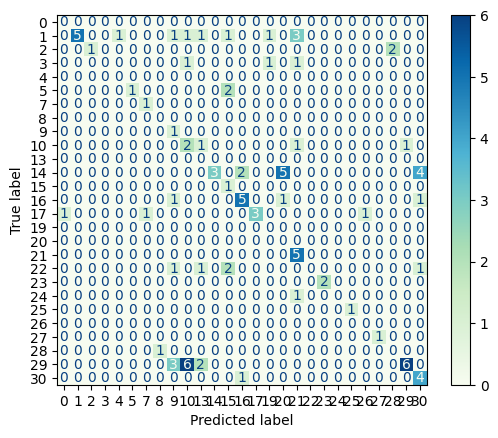

In [ ]:
# plot confusion matrix
plt.figure(figsize = (12, 23))
metrics.ConfusionMatrixDisplay.from_predictions(labels_sub_arr, labels_predict, cmap = "GnBu")

In [ ]:
# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(labels_sub_arr, labels_predict)
print("accuracy: " + str(accuracy))

accuracy: 0.4329896907216495
